In [ ]:
! pip install optuna --upgrade --quiet
! pip install optuna-dashboard --upgrade --quiet
! optuna-dashboard sqlite:///db.sqlite3 --upgrade --quiet

In [1]:
import optuna

def objective(trial):
    x = trial.suggest_float("x", -100, 100)
    y = trial.suggest_categorical("y", [-1, 0, 1])
    return x**2 + y

study = optuna.create_study(
    storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
    study_name="quadratic-simple"
)
study.optimize(objective, n_trials=100)
print(f"Best value: {study.best_value} (params: {study.best_params})")

[I 2024-04-28 20:04:31,245] A new study created in RDB with name: quadratic-simple
[I 2024-04-28 20:04:31,388] Trial 0 finished with value: 2344.39585561734 and parameters: {'x': -48.41896173625928, 'y': 0}. Best is trial 0 with value: 2344.39585561734.
[I 2024-04-28 20:04:31,473] Trial 1 finished with value: 2657.7173532416073 and parameters: {'x': -51.55305377222194, 'y': 0}. Best is trial 0 with value: 2344.39585561734.
[I 2024-04-28 20:04:31,550] Trial 2 finished with value: 7033.71124737237 and parameters: {'x': 83.87318550867357, 'y': -1}. Best is trial 0 with value: 2344.39585561734.
[I 2024-04-28 20:04:31,630] Trial 3 finished with value: 4586.3298285593155 and parameters: {'x': 67.72244700658206, 'y': 0}. Best is trial 0 with value: 2344.39585561734.
[I 2024-04-28 20:04:31,715] Trial 4 finished with value: 4722.617516242777 and parameters: {'x': 68.72130321990974, 'y': 0}. Best is trial 0 with value: 2344.39585561734.
[I 2024-04-28 20:04:31,795] Trial 5 finished with value: 88

Best value: 1.0003813381853845 (params: {'x': -0.019527882255498952, 'y': 1})


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import optuna

def TestScoreByFeatureImportanceThreshold(trial):
    feature_importance_threshold = trial.suggest_float("thr", 0, np.max(feature_importance)-1e-12)
    # Remove weak features
    weak_features_indexes = np.where(feature_importance < feature_importance_threshold)[0]
    train_features_selected = np.delete(train_features,weak_features_indexes,axis=1)
    test_features_selected = np.delete(test_features,weak_features_indexes,axis=1)
    # Test selected features
    oModel = RandomForestClassifier(n_estimators=100,min_samples_split=6,random_state=1,n_jobs=-1)
    oModel.fit(train_data,train_labels)
    accuracy = oModel.score(test_data,test_labels)
    return accuracy

study = optuna.create_study(
    storage="sqlite:///fit2.db",  # Specify the storage URL here.
    study_name="FeatureImportanceThreshold2"
)

study.optimize(TestScoreByFeatureImportanceThreshold, n_trials=100)
print(f"Best value: {study.best_value} (params: {study.best_params})")

In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
import sys
import optuna
import opendatasets as od
import csv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import seaborn as sns
import noisereduce as nr
from IPython.display import Audio
import librosa
import librosa.display
import wave

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

sys.path.append('C:\Study\TechnionAI\Victor\VoiceEmotionalAnalysis')
import prjLib as lib

import warnings
warnings.filterwarnings ('ignore')

In [4]:
# Parameters

FRAME_LEN = 4096
HOP_LEN = 2048
N_MFCC = 14

DOWN_SR = 2000 # 22050
SECS = 3
MAX_FILES = 13000

ravdess = ['RAVDESS','../data/ravdess-emotional-speech-audio']
tess = ['TESS','../data/toronto-emotional-speech-set-tess']
cremad = ['CREMA-D','../data/cremad/AudioWAV']
savee = ['SAVEE','../data/savee-database/AudioData']
data_paths = [ravdess,tess,cremad,savee] # ravdess,tess,cremad,savee

In [5]:
def TrainModel(train_data,train_labels,test_data,test_labels):
    oModel = RandomForestClassifier(n_estimators=100,min_samples_split=6,random_state=1,n_jobs=-1)
    oModel.fit(train_data,train_labels)
    accuracy = oModel.score(test_data,test_labels)
    return accuracy

In [6]:
def ExtractLabel(audio_file_path,dataset_name):
    emotion = -1
    gender = 0
    if (dataset_name == 'RAVDESS'):
        emotion = int(audio_file_path[7:8]) - 1
        gender = int(audio_file_path[18:20]) & 0x1
    if (dataset_name == 'TESS'):
        if '_neutral' in audio_file_path:
            emotion = 0
        if '_happy' in audio_file_path:
            emotion = 2
        if '_sad' in audio_file_path:
            emotion = 3
        if '_angry' in audio_file_path:
            emotion = 4
        if '_fear' in audio_file_path:
            emotion = 5
        if '_disgust' in audio_file_path:
            emotion = 6
        if '_ps' in audio_file_path:
            emotion = 7
        if 'OAF_' in audio_file_path:
            gender = 1
        if 'YAF_' in audio_file_path:
            gender = 0
    if (dataset_name == 'CREMA-D'):
        if '_NEU_' in audio_file_path:
            emotion = 0
        if '_HAP_' in audio_file_path:
            emotion = 2
        if '_SAD_' in audio_file_path:
            emotion = 3
        if '_ANG_' in audio_file_path:
            emotion = 4
        if '_FEA_' in audio_file_path:
            emotion = 5
        if '_DIS_' in audio_file_path:
            emotion = 6
        speaker_id = int(audio_file_path[0:4])
        # df = pd.read_csv('data/cremad/VideoDemographics.csv')
        # df = df.loc[df['ActorID'] == speaker_id]
        # gender = int(df['Sex'] == 'Male')
    if (dataset_name == 'SAVEE'):
        if 'n' in audio_file_path:
            emotion = 0
        if 'h' in audio_file_path:
            emotion = 2
        if 'sa' in audio_file_path:
            emotion = 3
        if 'a' in audio_file_path:
            emotion = 4
        if 'f' in audio_file_path:
            emotion = 5
        if 'd' in audio_file_path:
            emotion = 6
        if 'su' in audio_file_path:
            emotion = 7
        gender = 1
    return emotion # np.concatenate(np.array([emotion,gender]).reshape(1,2),axis=0)

In [7]:
# Preprocessing:
# Collect Data from audio files
ii=0
sample_data = np.zeros([MAX_FILES,SECS*2*DOWN_SR],dtype=np.float16)  # stores the features
labels = np.zeros([MAX_FILES,1],dtype=np.int8)  # stores the labels
for data_path in tqdm(data_paths,desc="Collecting Datasets"):
    root_dir = data_path[1]
    cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
    for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
        for file in files:
            if not '.wav' in file:
                continue
            audio_file_path = os.path.join(subdirs, file)
            sample, sr = librosa.load(audio_file_path,sr=DOWN_SR)
            sample_data[ii,:] = lib.FixSamples(sample,DOWN_SR,SECS)
            labels[ii,:] = ExtractLabel(file,data_path[0])
            ii += 1
sample_data = sample_data[:ii,:]
labels = labels[:ii,:]
print(f'Data with total {sample_data.shape[0]} audio samples collected, with {sample_data.shape[1]} samples each.')

Processing RAVDESS audio files:   0%|          | 0/25 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/16 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/1 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/5 [00:00<?, ?file/s]

Data with total 12162 audio samples collected, with 12000 samples each.


In [8]:
df_sample_data = lib.Numpy2Pandas(sample_data)
ds_labels = pd.DataFrame(labels, columns=['Emotion'])

In [9]:
ds_labels['Emotion'].replace({0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:1}, inplace=True)

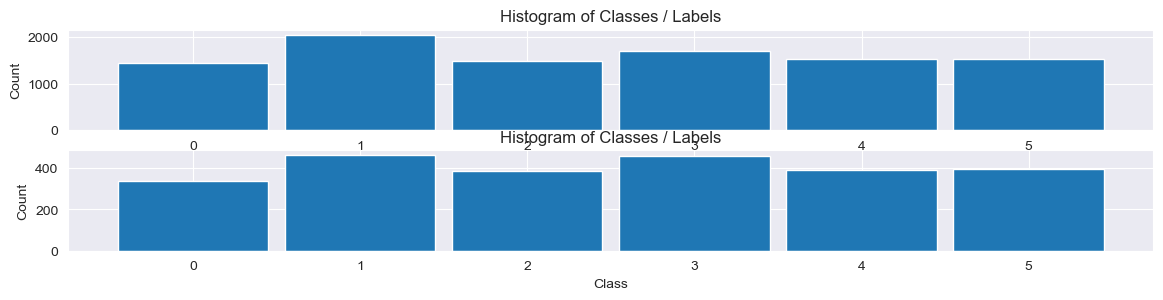

In [10]:
# Data samples split
train_data, test_data, train_labels, test_labels = train_test_split(df_sample_data, ds_labels, train_size = 0.8, random_state = 512)
train_labels.reset_index(drop=True,inplace=True)
test_labels.reset_index(drop=True,inplace=True)
lib.PlotSplitedDataHistogram(train_labels, test_labels)

In [11]:
def Normalize(train_data,test_data):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    train_data = lib.Numpy2Pandas(train_data)
    test_data = lib.Numpy2Pandas(test_data)
    return train_data,test_data

In [12]:
train_data,test_data = Normalize(train_data,test_data)

In [22]:
def ExtractFeatures_Test(sample,sr,n_fft,frame_len,hop_len,win_len,n_chroma):
    feature = librosa.feature.spectral_rolloff(y=sample, n_fft=n_fft, win_length=win_len, hop_length=hop_len)
    feature_mean = np.mean(feature,axis=1)
    feature_min = np.min(feature,axis=1)
    feature_max = np.max(feature,axis=1)
    features = np.concatenate((feature_mean, feature_min, feature_max),axis=0)
    return features

In [17]:
def ExtractFeaturesOnDataCollection(data,sr,n_fft,frame_len,hop_len,win_len,n_chroma):
    np_data = data.to_numpy()
    features = ExtractFeatures_Test(np_data[0,:],sr,n_fft,frame_len,hop_len,win_len,n_chroma)
    featured_data = np.zeros([np_data.shape[0],len(features)],dtype=np.float16)
    for ii in range(np_data.shape[0]):
        featured_data[ii,:] = ExtractFeatures_Test(np_data[ii,:],sr,n_fft,frame_len,hop_len,win_len,n_chroma)
    return featured_data

In [23]:
def TestByWindowing(n_fft,frame_len,hop_len,win_len,n_chroma):
    test_features = ExtractFeaturesOnDataCollection(test_data,DOWN_SR,n_fft,frame_len,hop_len,win_len,n_chroma)
    train_features = ExtractFeaturesOnDataCollection(train_data,DOWN_SR,n_fft,frame_len,hop_len,win_len,n_chroma)
    accuracy = TrainModel(train_features,train_labels,test_features,test_labels)
    return accuracy

def oWindowing(trial):
    n_fft = trial.suggest_int("n_fft", 1, DOWN_SR*4)
    #frame_len = trial.suggest_int("frame_len", 1, DOWN_SR*4)
    hop_len = trial.suggest_int("hop_len", 1, n_fft)
    win_len = trial.suggest_int("win_len", 1, n_fft)
    #n_chroma = trial.suggest_int("n_chroma", 1, 128)
    score = TestByWindowing(n_fft,0,hop_len,win_len,0)
    return score

study_name="Windowing_18"
study = optuna.create_study(
    study_name=study_name,
    storage=f'sqlite:///{study_name}.db',  # Specify the storage URL here.
    direction='maximize'
)

study.optimize(oWindowing, n_trials=100)
#score = TestByWindowing(study.best_params['thr'])

print(f"Best score: {study.best_value} (params: {study.best_params})")

[I 2024-05-02 14:43:46,876] A new study created in RDB with name: Windowing_18
[I 2024-05-02 14:44:08,770] Trial 0 finished with value: 0.2178380600082203 and parameters: {'n_fft': 5598, 'hop_len': 4943, 'win_len': 1119}. Best is trial 0 with value: 0.2178380600082203.
[I 2024-05-02 14:47:17,843] Trial 1 finished with value: 0.3156596794081381 and parameters: {'n_fft': 7861, 'hop_len': 653, 'win_len': 3096}. Best is trial 1 with value: 0.3156596794081381.
[I 2024-05-02 14:47:55,355] Trial 2 finished with value: 0.2326346074804768 and parameters: {'n_fft': 3251, 'hop_len': 1797, 'win_len': 368}. Best is trial 1 with value: 0.3156596794081381.
[I 2024-05-02 14:48:37,497] Trial 3 finished with value: 0.2157829839704069 and parameters: {'n_fft': 3653, 'hop_len': 1322, 'win_len': 133}. Best is trial 1 with value: 0.3156596794081381.
[I 2024-05-02 14:48:58,028] Trial 4 finished with value: 0.2815454171804357 and parameters: {'n_fft': 582, 'hop_len': 268, 'win_len': 557}. Best is trial 1 with

KeyboardInterrupt: 